# Safety Filtering
```Author: Kensuke Nakamura```

```Acknowledgements: MPPI planner and Intent Lab floorplans from Leonardo Santos```



In this, we will computationally synthesize and deploy a *safety filter*. We will use Hamilton-Jacobi (HJ) reachability as our safety filter synthesis tool. This will involve computing a backward reachable tube (BRT) for our dynamical system of choice.


In [13]:
# # @title Install and import dependencies
# !gdown 1UATUlH4Xer6qq5XN4UoFoVZT0OSLSkeR
# !pip install --upgrade pip
# !pip install "flax>=0.6.6"
# !pip install -U "jax[cuda12]"
# !pip install "numpy>=1.22"
# !pip install --upgrade hj-reachability

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Select GPU 1
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [15]:
# for directories and paths
import os

# for math operations
import numpy as np
import scipy

# for plotting
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# for accelerated computing
import jax
import jax.numpy as jnp

# Python reachability toolbox
import hj_reachability as hj

## Problem 1: Multi-Obstacle Safety Policy

In class, we went over how we can derive a safety filter for a vehicle-like robot modeled as its position and heading $x := (p_x, p_y, \theta)$. We will model the robot's continuous-time dynamics via this ordinary differential equation (ODE) below:

\begin{align}
\dot{p}_x &= v \cos(\theta) \\
\dot{p}_y &= v \sin(\theta) \\
\dot{\theta} &= \omega
\end{align}

This robot model is often called a 3D Dubins' car model. The robot’s linear velocity is fixed $v = 0.5$ m/s and it controls its angular velocity, $u := \omega$ which is bounded, $\omega \in [-1, 1]$. Assume the failure set $\mathit{F}$ represents an obstacle centered at $(0, 1)$ and contains any state within a 0.5 m radius circle in the $p_x$-$p_y$ plane irrespective of the heading angle.

1. Mathematically define a signed distance function $\ell(x)$ which encodes $\mathit{F}$ as the sub-zero
level set.

2. Suppose there was another obstacle identical to the first, centered at (x_c, y_c). How could we design a single signed distance function $\ell(x)$ whose zero-sublevel set describes the failure set $\mathit{F}$ induced by both obstacles?

  HINT: Imagine you have two signed distance functions $\ell_{o1}$, $\ell_{o_2}$. Each signed distance function represents the distance from any point in the space to the corresponding obstacle. How could we compose these functions to get a single $\ell(x)$ representing the distance to the nearest obstacle?

3. True or False: The union of unsafe sets for two failure sets is the same as the unsafe set of the union of two failure sets. Explain.

### Solutions

1.5.1 **TODO: your Markdown solution here.**  

$l(x) = (x - 0)^2 + (y-1)^2 - 0.5^2$

1.5.2 **TODO: your Markdown solution here.**  

$l_1(x) = (x - 0)^2 + (y-1)^2 - 0.5^2$

$l_2(x) = (x - x_c)^2 + (y-y_c)^2 - 0.5^2$

$l(x) = min(l_1(x), l_2(x))$


1.5.3. **TODO: your Markdown solution here.**  


False.

The unsafe set resulting from a failure set $\mathit{F}_1$ is the set of state where the system is doomed to enter $\mathit{F}_1$. However, there may exist a state where avoiding $\mathit{F}_1$ requires you to enter $\mathit{F}_2$. To illustrate this, try the coding question that follows.

## Numerically Computing Safety Filters via HJ Reachability Analysis

Now let's compute the backwards reachable tube for the same dynamical system above!

In [16]:
# @title 3D Dubins Car Dynamics
import jax.numpy as jnp

from hj_reachability import dynamics
from hj_reachability import sets
import torch

speed = 1.
class Dubins3D(dynamics.ControlAndDisturbanceAffineDynamics):
    def __init__(self,
                 max_turn_rate=1.25,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None):
        self.speed = speed
        if control_space is None:
            control_space = sets.Box(jnp.array([-max_turn_rate]), jnp.array([max_turn_rate]))
        if disturbance_space is None:
            disturbance_space = sets.Box(jnp.array([0, 0]), jnp.array([0, 0]))
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        _, _, psi = state
        v = self.speed
        return jnp.array([v * jnp.cos(psi), v * jnp.sin(psi), 0.])

    def control_jacobian(self, state, time):
        x, y, _ = state
        return jnp.array([
            [0],
            [0],
            [1],
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [1., 0.],
            [0., 1.],
            [0., 0.],
        ])


def dubins_dynamics_tensor(current_state: torch.Tensor, action: torch.Tensor, dt: float) \
        -> torch.Tensor:
    """
    current_state: shape(num_samples, dim_x)
    action: shape(num_samples, dim_u)

    Implemented discrete time dynamics with RK-4.

    return:
    next_state: shape(num_samples, dim_x)
    """

    def one_step_dynamics(state, action):
        """Compute the derivatives [dx/dt, dy/dt, dtheta/dt]."""
        x_dot = speed*torch.cos(state[:, 2])
        y_dot = speed*torch.sin(state[:, 2])
        theta_dot = action[:, 0]
        return torch.stack([y_dot, x_dot, theta_dot], dim=1)

    # k1
    k1 = one_step_dynamics(current_state, action)
    # k2
    mid_state_k2 = current_state + 0.5 * dt * k1
    k2 = one_step_dynamics(mid_state_k2, action)
    # k3
    mid_state_k3 = current_state + 0.5 * dt * k2
    k3 = one_step_dynamics(mid_state_k3, action)
    # k4
    end_state_k4 = current_state + dt * k3
    k4 = one_step_dynamics(end_state_k4, action)
    # Combine k1, k2, k3, k4 to compute the next state
    next_state = current_state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    next_state[..., -1] = next_state[..., -1] % (2 * np.pi)
    return next_state


Let's instantiate our dynamical system $\dot{x} = f(x, u)$, the state space computation grid $x \in X$, and the margin function $\ell(x)$.

**1.2 TODO: Implement $\ell(x)$ below.**

In [17]:
dim = 31

100%|##########|  2.8000/2.799999952316284 [00:00<00:00, 34.45sim_s/s]


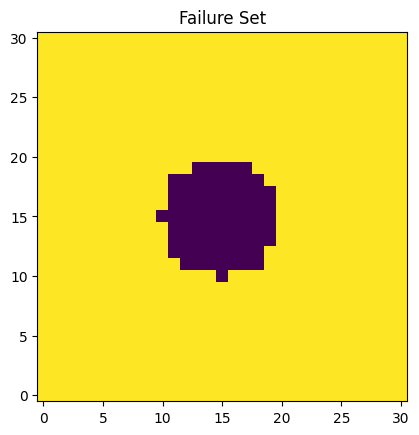

In [18]:
# Define the dynamical system
dyn_sys = Dubins3D()

# Define the computation grid
grid_min = np.array([-1.5, -1.5, 0.]) # in meters
grid_max = np.array([1.5, 1.5, 2 * np.pi]) # in meters
num_cells = (dim, dim, dim) # in cells
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(grid_min, grid_max),
                                                               num_cells,
                                                               periodic_dims=2)

# Define the failure set as encoded by a signed distance function.
# We use values to denote this initial signed distance function from
# which the value function is computed.
x_c, y_c, radius = -0.0, -0.0, 0.5
obstacle1 = jnp.linalg.norm(np.array([0.0, 0.0]) - grid.states[..., :2], axis=-1) - radius
# obstacle2 = jnp.linalg.norm(np.array([x_c, y_c]) - grid.states[..., :2] , axis=-1) - radius
failure_lx = obstacle1

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
# Time
time = 0.
target_time = -2.8

dt = 0.05
time_values = jnp.arange(0., -2.8 - dt, -dt)

# Run the solver
target_values = hj.solve(solver_settings, dyn_sys, grid, time_values, failure_lx)
# target_values = hj.step(solver_settings, dyn_sys, grid, time, failure_lx, target_time)
plt.title("Failure Set")
plt.imshow(failure_lx[:, :, 0].T>0, origin='lower')
plt.show()


**1.3 Visualize the zero-sublevel set for 2 different values of theta at $(x_c, y_c) = (-1, -1)$ and $(x_c, y_c) = (0, -0.98)$.***

This means to compute the BRT two times, each having two obstacles. The first BRT computation should have an obstacle at the origin, and the other at (-1, -1). The next BRT computation should have an obstacle at the origin, and the other at (0, -0.98).

TODO: Your Markdown solution

**1.4 Why do the shape of these BRTs look different??**


TODO: Your Markdown solution

The BRTs look different because in the first case, you can avoid each obstacle without forcing the Dubin's car to collide with the other obstacle. This ends up looking something like the union of two unsafe sets. However, for the second set of obstacles, there are states that are unsafe because the Dubin's car will inevitably hit at least one of the obstacles. This forces the BRT to be larger than the union of the individual BRTs of each obstacle.


[[0.78062475]]
[[0.78062475]]


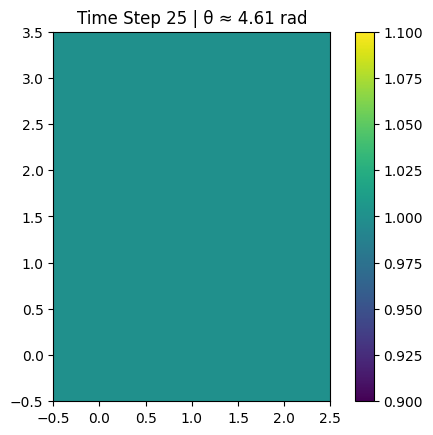

[[0.78062475]]
[[0.78062475]]


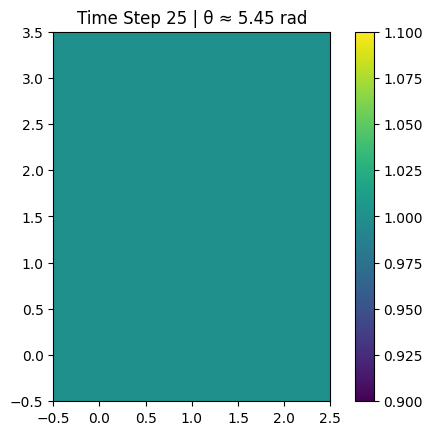

[[0.66604805]]
[[0.58250445]]


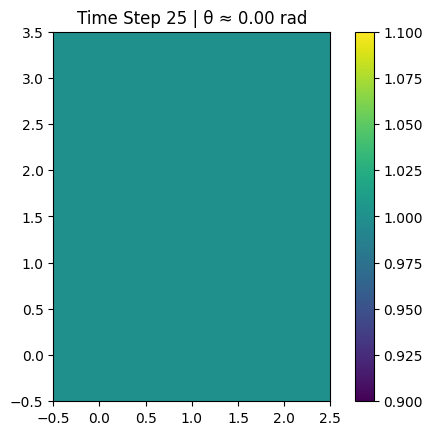

In [19]:
# Define the target thetas
thetas = [3*np.pi/2, 7*np.pi/4, 0]

# Define theta values
theta_values = jnp.linspace(0, 2 * jnp.pi, dim)

# Function to find the closest index for a given theta
def find_closest_theta_index(theta_value, theta_values):
    return jnp.argmin(jnp.abs(theta_values - theta_value))


saved_slices = {}

# Loop through desired thetas
for theta in thetas:
    theta_index = find_closest_theta_index(theta, theta_values)
    
    slice_data = np.array(target_values[25, :, :, theta_index])
    # Store in dictionary with readable key
    key = f"theta_{theta:.4f}_rad"
    saved_slices[key] = slice_data
    # Visualize for time index 25
    print(target_values[25, 7:8, 5:6, theta_index].T)
    print(target_values[25, 5:6, 7:8, theta_index].T)
    plt.imshow(target_values[25, 6:9, 5:9, theta_index].T > 0, origin='lower')
    plt.title(f"Time Step 25 | θ ≈ {theta_values[theta_index]:.2f} rad")
    plt.colorbar()
    plt.show()

np.savez(f"../gt_dubins/value_function_theta_slices_{dim}.npz", **saved_slices)

In [20]:
theta_index = find_closest_theta_index(3*np.pi/2, theta_values)
gt = np.array(target_values[25, :, :, theta_index])
diff = np.load('../test1.npy') # pred - gt

gt = np.load('../test2.npy')
pred = np.load('../test3.npy')

# diff2 = (diff - pred) * -1
diff2 = diff
diff2.shape

(31, 31)

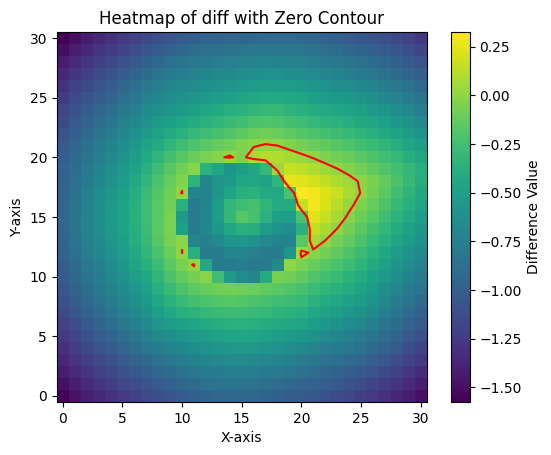

In [21]:
Y, X = np.meshgrid(np.arange(diff2.shape[0]), np.arange(diff2.shape[1]), indexing='ij')

# Plot heatmap
plt.imshow(diff2, cmap='viridis', origin='lower')
plt.colorbar(label='Difference Value')

# Add contour where value = 0
plt.contour(X, Y, diff2, levels=[0], colors='red', linewidths=1.5)

plt.title('Heatmap of diff with Zero Contour')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

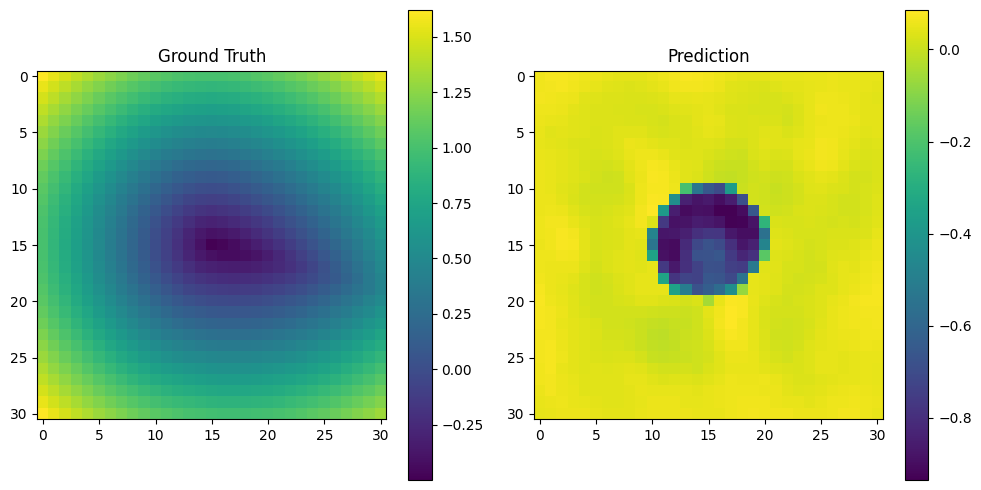

In [22]:
# Plotting
plt.figure(figsize=(10, 5))

# Ground truth
plt.subplot(1, 2, 1)
plt.imshow(gt, cmap='viridis')
plt.title('Ground Truth')
plt.colorbar()

# Prediction
plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='viridis')
plt.title('Prediction')
plt.colorbar()

plt.tight_layout()
plt.show()

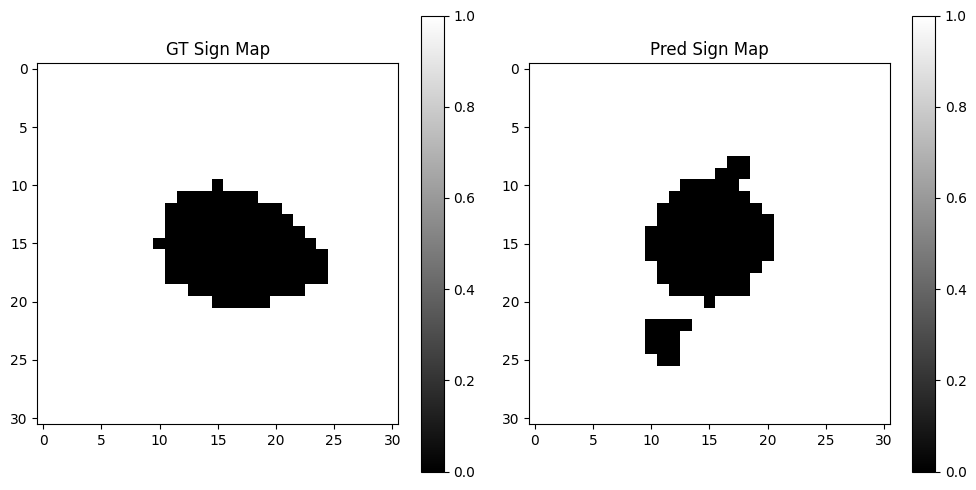

In [23]:
# Load the arrays
gt = np.load('../test2.npy')
pred = np.load('../test3.npy')

# Create sign maps
gt_sign = (gt > 0).astype(int)
pred_sign = (pred > 0).astype(int)

# Plotting
plt.figure(figsize=(10, 5))

# GT sign map
plt.subplot(1, 2, 1)
plt.imshow(gt_sign, cmap='gray')
plt.title('GT Sign Map')
plt.colorbar()

# Pred sign map
plt.subplot(1, 2, 2)
plt.imshow(pred_sign, cmap='gray')
plt.title('Pred Sign Map')
plt.colorbar()

plt.tight_layout()
plt.show()

In [24]:
# Flatten the arrays (optional, but helps for clarity)
gt_flat = gt_sign.flatten()
pred_flat = pred_sign.T.flatten()

# Compute metrics
tp = np.sum((pred_flat == 1) & (gt_flat == 1))
tn = np.sum((pred_flat == 0) & (gt_flat == 0))
fp = np.sum((pred_flat == 1) & (gt_flat == 0))
fn = np.sum((pred_flat == 0) & (gt_flat == 1))

# Print results
print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn}")


TP: 823
TN: 80
FP: 32
FN: 26
